In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
# VGG11
# 64x3x32x32 -> (64)64x64x32x32 -> (M)64x64x16x16 -> (128)64x128x16x16 -> (M)64x128x8x8->
# (256)64x256x8x8 -> (256)64x256x8x8 -> (M)64x256x4x4 -> (512)64x512x4x4 -> (512)64x512x4x4 ->
# (M)64x512x2x2 -> (FC)64x10

cfg = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}

class VGG(nn.Module):
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                nn.BatchNorm2d(x),
                nn.ReLU(inplace=True)]
                in_channels = x

        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [6]:
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
)

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=32)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=32)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


[訓練]エポック:1 バッチ:1/391 損失:2.487 正解率:9.375%
[訓練]エポック:1 バッチ:101/391 損失:3.561 正解率:10.249%
[訓練]エポック:1 バッチ:201/391 損失:2.928 正解率:11.004%
[訓練]エポック:1 バッチ:301/391 損失:2.676 正解率:12.850%
[検証]エポック:1 バッチ:500/500 損失:1.972 正解率:20.268%
ベストな正解率を更新しました: 0 -> 20.268%
[訓練]エポック:2 バッチ:1/391 損失:1.911 正解率:24.219%
[訓練]エポック:2 バッチ:101/391 損失:1.930 正解率:21.264%
[訓練]エポック:2 バッチ:201/391 損失:1.917 正解率:22.062%
[訓練]エポック:2 バッチ:301/391 損失:1.899 正解率:23.097%
[検証]エポック:2 バッチ:500/500 損失:1.465 正解率:28.900%
ベストな正解率を更新しました: 20.268 -> 28.9%
[訓練]エポック:3 バッチ:1/391 損失:1.714 正解率:30.469%
[訓練]エポック:3 バッチ:101/391 損失:1.722 正解率:32.488%
[訓練]エポック:3 バッチ:201/391 損失:1.688 正解率:33.699%
[訓練]エポック:3 バッチ:301/391 損失:1.667 正解率:34.689%
[検証]エポック:3 バッチ:500/500 損失:1.285 正解率:39.192%
ベストな正解率を更新しました: 28.9 -> 39.192%
[訓練]エポック:4 バッチ:1/391 損失:1.682 正解率:33.594%
[訓練]エポック:4 バッチ:101/391 損失:1.499 正解率:43.386%
[訓練]エポック:4 バッチ:201/391 損失:1.471 正解率:44.706%
[訓練]エポック:4 バッチ:301/391 損失:1.447 正解率:45.738%
[検証]エポック:4 バッチ:500/500 損失:1.110 正解率:51.396%
ベストな正解率を更新しました: 39.192 -> 51.396%
[訓

Text(0.5, 1.0, 'VGG11 CIFAR-10')

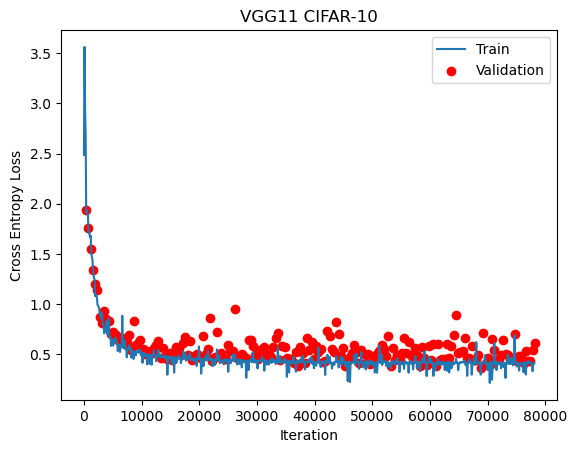

In [26]:
net = VGG("VGG11").cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
best_acc = 0

log_train_x = []
log_train_y = []
log_val_x = []
log_val_y = []

for epoch in range(1, 201):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            log_train_x.append(len(trainloader) * (epoch - 1) + batch_idx)
            log_train_y.append(train_loss / (batch_idx + 1))
            print(f"[訓練]エポック:{epoch} バッチ:{batch_idx+1}/{len(trainloader)} 損失:{train_loss/(batch_idx+1):.3f} 正解率:{100.*correct/total:.3f}%")

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    log_val_x.append(len(trainloader) * epoch)
    log_val_y.append(test_loss / (batch_idx + 1))

    print(f"[検証]エポック:{epoch} バッチ:{batch_idx+1}/{len(testloader)} 損失:{train_loss/(batch_idx+1):.3f} 正解率:{100.*correct/total:.3f}%")
            
    acc = 100. * correct / total
    if acc > best_acc:
        print(f"ベストな正解率を更新しました: {best_acc} -> {acc}%")
        state = { "net": net.state_dict(), "acc": acc, "epoch": epoch }
        torch.save(state, "models/vgg11.pth")
        best_acc = acc

plt.plot(log_train_x, log_train_y, label="Train")
plt.scatter(log_val_x, log_val_y, label="Validation", color="red")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cross Entropy Loss")
plt.title("VGG11 CIFAR-10")

2